In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram_shift, illumination_beam
from project.algorithms.utils import circ_aperture, normalize, ft, ift, frashift, nrmse
from project.algorithms.reconstruction import update_obj, update_probe, TransRefinement

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [3]:
"ground truth"
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape = (161, 161)   # the size of reconstruction box
r = 0.5
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)

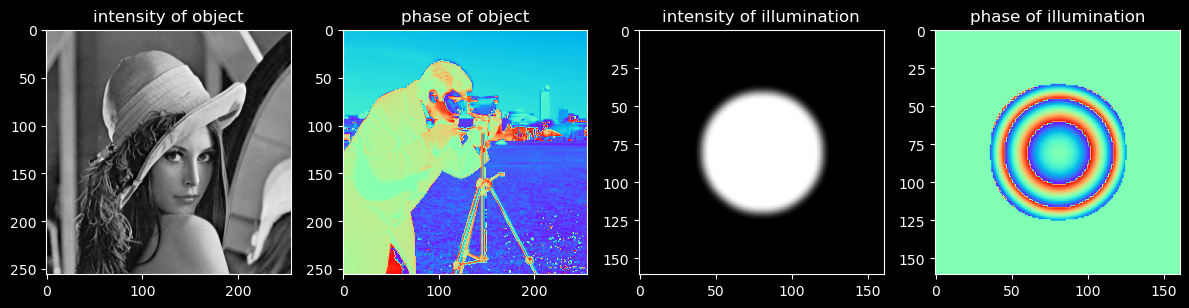

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(obj), cmap='gray')
axes[0].set_title('intensity of object')
axes[1].imshow(np.angle(obj), cmap='rainbow')
axes[1].set_title('phase of object')
axes[2].imshow(np.abs(illumination), cmap='gray')
axes[2].set_title('intensity of illumination')
axes[3].imshow(np.angle(illumination), cmap='rainbow')
axes[3].set_title('phase of illumination')
plt.tight_layout()

In [5]:
"positions and ptychogram"
positions = np.load('positions.npy').astype('float')
patterns = []
for position in positions:
    pattern = ptychogram_shift(obj, illumination, position)
    patterns.append(pattern)

In [6]:
"initial estimation and parameter"
guess_probe = circ_aperture(box_shape, radius=0.4).astype('complex')
# guess_probe = illumination
guess_obj = np.ones(obj.shape, dtype="complex")

In [36]:
if True:
    guess_positions = np.load('temp_guess.npy').astype('float64')
else:
    guess_positions = positions.copy()
    num_IPs = 20
    IPs = np.random.choice(49, num_IPs, replace=False)
    max_error = 10
    x_error = np.random.uniform(-1, 1, num_IPs) * max_error
    y_error = np.random.uniform(-1, 1, num_IPs) * max_error
    guess_positions[IPs,0] += y_error
    guess_positions[IPs,1] += x_error
    np.save('temp_guess.npy',guess_positions)

In [37]:
error = positions-guess_positions
dis = np.sqrt(np.sum((error ** 2), axis=1))
mpe = np.mean(dis)
print(mpe)
print(np.sum(dis<1))
print(np.sum(dis>1))

3.2756884637882324
29
20


In [38]:
(K, L) = guess_probe.shape
(M, N) = guess_obj.shape
a, b = 1., 1.
sy, sx, sx1, sy1 = [], [], [], []
beta = [300, 300]
jump = 50

for n in range(100):
    index = np.random.choice(49, 49, replace=False)
    for i in index:
    # for i in range(49):
        x = guess_positions[i][1]
        y = guess_positions[i][0]
        pattern = patterns[i]
        shift = -np.array([y - M//2, x - N//2]).astype('float')
        guess_obj = frashift(guess_obj, shift)
        obj_scanned = guess_obj[M//2 -K//2 : M//2+K//2+1, N//2-L//2 : N//2+L//2+1]

        "revise the wave function in diffraction plane"
        psi = obj_scanned * guess_probe
        Psi = ft(psi)
        phase_Psi = np.exp(1j * np.angle(Psi))
        Psi_corrected = np.sqrt(pattern) * phase_Psi
        psi_corrected = ift(Psi_corrected)

        "update the object and probe functions"
        diff_psi = psi_corrected - psi
        temp_obj = obj_scanned.copy()
        obj_scanned = update_obj(obj_scanned, guess_probe, diff_psi, learning_rate=a)
        guess_obj[M//2 -K//2 : M//2+K//2+1, N//2-L//2 : N//2+L//2+1] = obj_scanned
        guess_obj = frashift(guess_obj, -shift)
        guess_probe = update_probe(guess_probe, temp_obj, diff_psi, learning_rate=b)

        NRMSE = (nrmse(np.abs(Psi), np.sqrt(pattern)))

        "just update IPs"
        # if i in IPs:
        #     syj, sxj = TransRefinement(obj_scanned, temp_obj, integer_skip=False)
        #     if n >= 20:
        #         dy, dx = syj * beta[0], sxj * beta[1]
        #         y -= dy
        #         x -= dx
        #         guess_positions[i] = np.array([y, x])

        "full update"
        if n >=20:
            if NRMSE > 0.1:
                syj, sxj = TransRefinement(obj_scanned, temp_obj, integer_skip=False)
                dy, dx = syj * beta[0], sxj * beta[1]
                y -= dy
                x -= dx
                guess_positions[i] = np.array([y, x])

    # if jump >= jump + 30:


In [39]:
np.max(np.abs(positions-guess_positions))

8.522395269450328

In [40]:
error = positions-guess_positions
dis = np.sqrt(np.sum((error ** 2), axis=1))
mpe = np.mean(dis)
print(mpe)
print(np.sum(dis<1))
print(np.sum(dis>1))

2.879279677094974
7
42


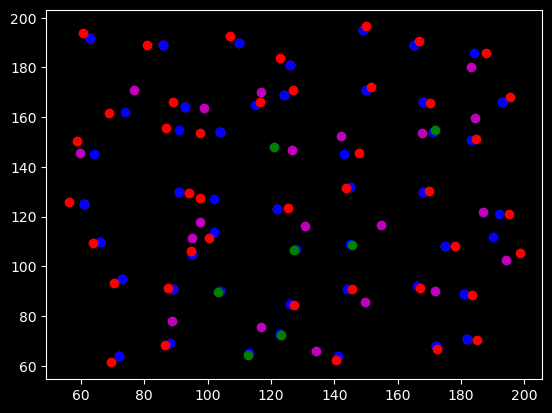

In [41]:
plt.figure()
plt.scatter(*np.transpose(np.load('temp_guess.npy')), color='m')
plt.scatter(*np.transpose(positions), color='b')
plt.scatter(*np.transpose(guess_positions[dis<=1]), color='g')
plt.scatter(*np.transpose(guess_positions[dis>1]), color='r')

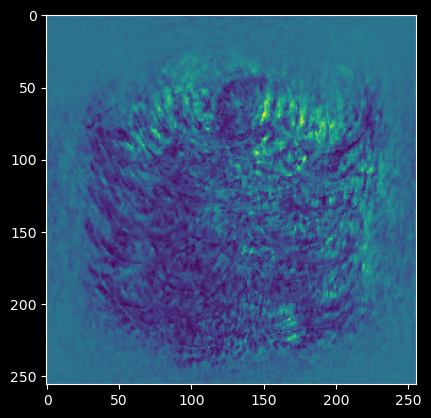

In [13]:
plt.imshow(np.abs(guess_obj))